In [1]:
import pandas as pd
import numpy as np

# data = pd.read_csv('data/breast-cancer-wisconsin.data.txt', header=None)
# data.columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 
#                 'Uniformity of Cell Shape', 'Marginal Adhesion', 
#                 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 
#                 'Normal Nucleoli', 'Mitoses', 'Class']
# data = data.replace('?', np.NaN)
# data.to_csv('breast-cancer-wisconsin.data.csv', index=False)
# print(data.isnull().sum())
# print(data.shape)
# print('\nNumber of samples per class(all):\n',
#       np.asarray(np.unique(data['Class'], return_counts=True)).T)

data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
data.columns = ['id', 'diagnosis'] + [d + ' ' + feat for d in 
                                      ['mean', 'standard error', 'worst'] 
                                      for feat in ['radius', 'texture', 
                                                   'perimeter', 'area', 'smoothness',
                                                   'compactness', 'concavity', 
                                                   'concave points', 'symmetry', 
                                                   'fractal dimension']]
data.to_csv('breast-cancer-wisconsin.data.csv', index=False)
print(data.shape)
print('\nNumber of samples per class:\n',
      np.asarray(np.unique(data['diagnosis'], return_counts=True)).T)
# data.to_csv('wdbc.data.csv', index=False)
data.head(5)

(569, 32)

Number of samples per class:
 [['B' 357]
 ['M' 212]]


,id,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
mapping = {'B': 0, 'M': 1}
y_true = data['diagnosis'].map(mapping).values
X = data.drop(['id', 'diagnosis'], axis=1).values
print(X.shape, y_true.shape)
print(np.asarray(np.unique(y_true, return_counts=True)).T)

(569, 30) (569,)
[[  0 357]
 [  1 212]]


In [3]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter=4000, random_state=0)
Y_tsne = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.003s...
[t-SNE] Computed neighbors for 569 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 33.679705
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.846668
[t-SNE] Error after 4000 iterations: 0.216647


In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
y_kmeans = kmeans.fit_predict(X)

from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score

def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)

print(contingency_matrix(y_true, y_kmeans))
print('adjusted_rand_score =', adjusted_rand_score(y_true, y_kmeans))
print('purity =', purity_score(y_true, y_kmeans))
print(accuracy_score(y_true, y_kmeans))
print('Clustering accuracy:', 1 - np.sum(abs(y_kmeans-y_true))/X.shape[0])

[[356   1]
 [ 82 130]]
adjusted_rand_score = 0.49142453622455523
purity = 0.8541300527240774
0.8541300527240774
Clustering accuracy: 0.8541300527240774


In [5]:
pred = KMeans(n_clusters=2, init='random', tol=1, 
              max_iter=1, random_state=0).fit_predict(X)

print(contingency_matrix(y_true, pred))
print('adjusted_rand_score =', adjusted_rand_score(y_true, pred))
print('purity =', purity_score(y_true, pred))
print(accuracy_score(y_true, pred))
print('Clustering accuracy:', 1 - np.sum(abs(pred-y_true))/X.shape[0])

[[  1 356]
 [115  97]]
adjusted_rand_score = 0.4157951325264237
purity = 0.827768014059754
0.17223198594024605
Clustering accuracy: 0.17223198594024602


Note: A straightforward way to find the mapping between two clusters and two 
classes can be an 2x2 contingency matrix. The entries will just be the overlaps. 
t-SNE is definitely overkill and it is only for visualization. It also brings 
additional uncertainties.

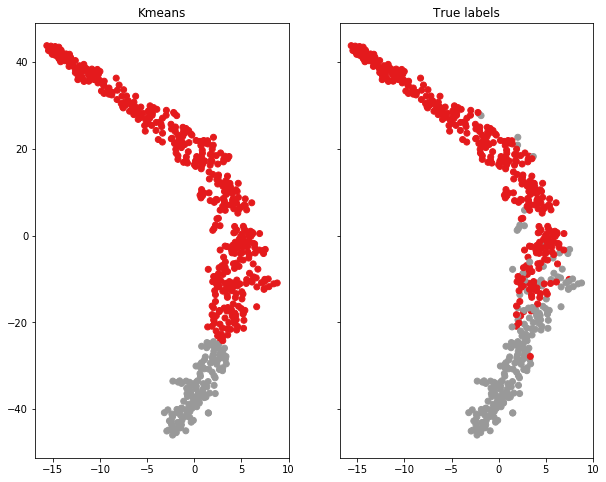

In [6]:
% matplotlib inline
import matplotlib.pyplot as plt
def display_cluster(y_true, y_pred, method='Kmeans'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
    
    ax1.scatter(Y_tsne[:,0], Y_tsne[:,1], c=y_pred, cmap='Set1')
    ax1.set_title(method)

    ax2.scatter(Y_tsne[:,0], Y_tsne[:,1], c=y_true, cmap='Set1')
    ax2.set_title('True labels')
    plt.show()
    
display_cluster(y_true, y_kmeans, 'Kmeans')

[[357   0]
 [126  86]]
adjusted_rand_score = 0.2872456066095377
purity = 0.7785588752196837
0.7785588752196837
Clustering accuracy: 0.7785588752196837


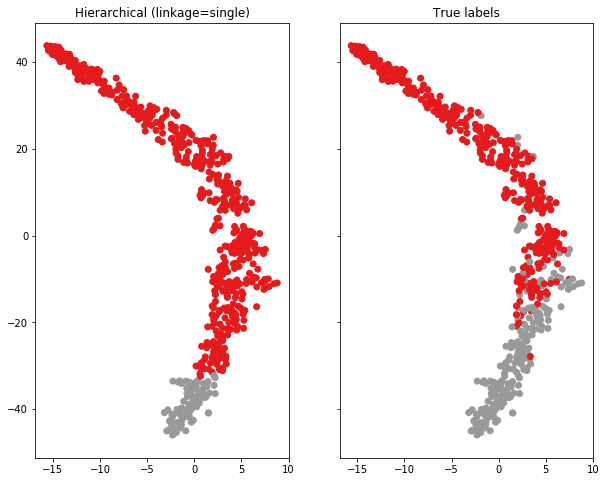

In [7]:
from sklearn.cluster import AgglomerativeClustering
agg_single = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_agg_single = agg_single.fit_predict(X)
print(contingency_matrix(y_true, y_agg_single))
print('adjusted_rand_score =', adjusted_rand_score(y_true, y_agg_single))
print('purity =', purity_score(y_true, y_agg_single))
print(accuracy_score(y_true, y_agg_single))
print('Clustering accuracy:', 1 - np.sum(abs(y_agg_single-y_true))/X.shape[0])

display_cluster(y_true, y_agg_single, 'Hierarchical (linkage=single)')

[[  0 357]
 [ 20 192]]
adjusted_rand_score = 0.05230450912720373
purity = 0.6625659050966608
0.3374340949033392
Clustering accuracy: 0.3374340949033392


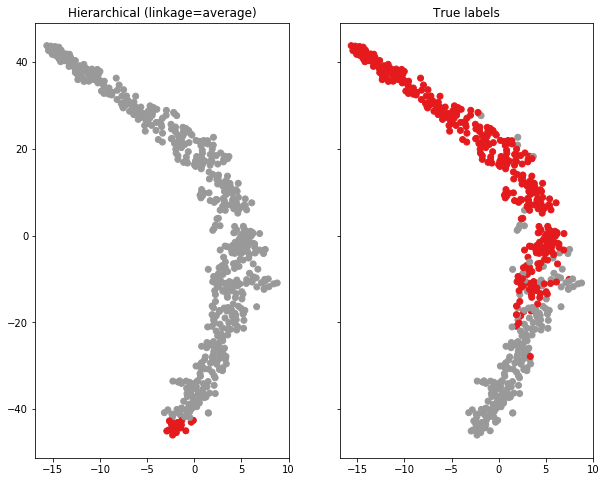

In [8]:
agg_average = AgglomerativeClustering(n_clusters=2, linkage='average')
y_agg_average = agg_average.fit_predict(X)
print(contingency_matrix(y_true, y_agg_average))
print('adjusted_rand_score =', adjusted_rand_score(y_true, y_agg_average))
print('purity =', purity_score(y_true, y_agg_average))
print(accuracy_score(y_true, y_agg_average))
print('Clustering accuracy:', 1 - np.sum(abs(y_agg_average-y_true))/X.shape[0])

display_cluster(y_true, y_agg_average, 'Hierarchical (linkage=average)')

[[  0 357]
 [ 20 192]]
adjusted_rand_score = 0.05230450912720373
purity = 0.6625659050966608
0.3374340949033392
Clustering accuracy: 0.3374340949033392


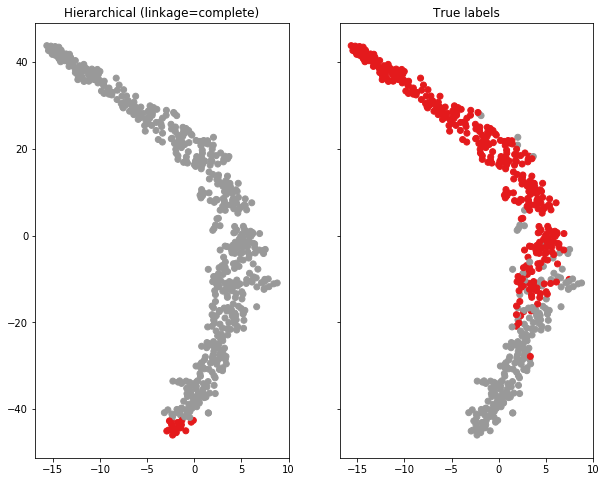

In [9]:
agg_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
y_agg_complete = agg_complete.fit_predict(X)
print(contingency_matrix(y_true, y_agg_complete))
print('adjusted_rand_score =', adjusted_rand_score(y_true,y_agg_complete))
print('purity =', purity_score(y_true, y_agg_complete))
print(accuracy_score(y_true, y_agg_complete))
print('Clustering accuracy:', 1 - np.sum(abs(y_agg_complete-y_true))/X.shape[0])

display_cluster(y_true, y_agg_complete, 'Hierarchical (linkage=complete)')

explained_variance_ratio_ = 1.0
(569, 30) (569, 30)


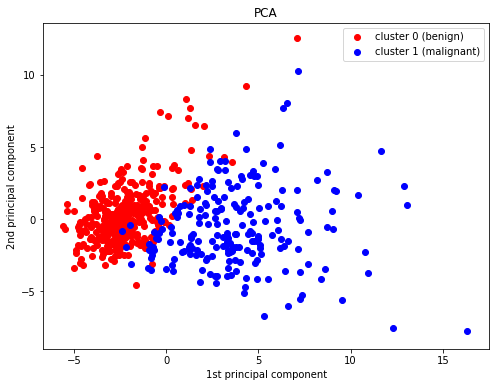

In [10]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X_scale)
print('explained_variance_ratio_ =', sum(pca.explained_variance_ratio_))
print(X.shape, X_pca.shape)

def PCA_visualization(X, y):
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(X[y==0, 0], X[y==0, 1],
                color='red', label='cluster 0 (benign)')
    plt.scatter(X[y==1, 0], X[y==1, 1],
                color='blue', label='cluster 1 (malignant)')
    plt.xlabel('1st principal component')
    plt.ylabel('2nd principal component')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA')
    plt.show()
    
PCA_visualization(X_pca, y_true)

[[339  18]
 [ 36 176]]
adjusted_rand_score = 0.6536246043910179
purity = 0.9050966608084359
0.9050966608084359
Clustering accuracy: 0.9050966608084359


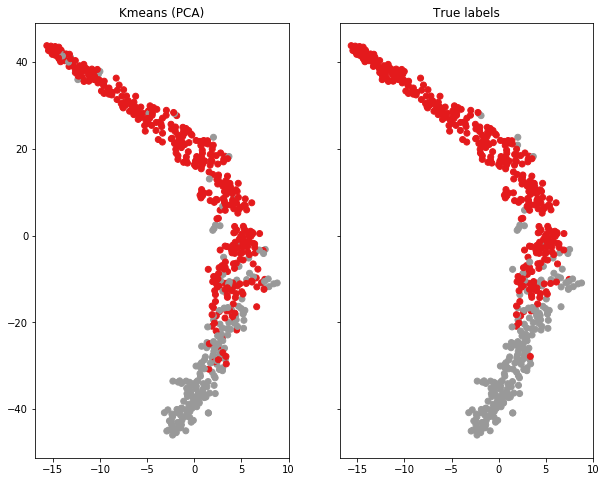

In [11]:
kmeans_pca = KMeans(n_clusters=2, random_state=0)
y_kmeans_pca = kmeans_pca.fit_predict(X_pca)

print(contingency_matrix(y_true, y_kmeans_pca))
print('adjusted_rand_score =', adjusted_rand_score(y_true, y_kmeans_pca))
print('purity =', purity_score(y_true, y_kmeans_pca))
print(accuracy_score(y_true, y_kmeans_pca))
print('Clustering accuracy:', 1 - np.sum(abs(y_kmeans_pca-y_true))/X.shape[0])
display_cluster(y_true, y_kmeans_pca, 'Kmeans (PCA)')

explained_variance_ratio_ = 0.8473427431678687


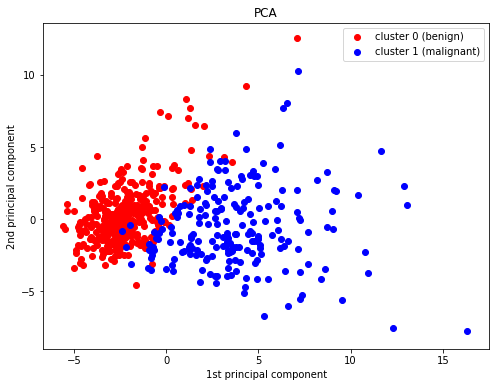

[[343  14]
 [ 37 175]]
0.9103690685413005
adjusted_rand_score = 0.6707206476880808
purity = 0.9103690685413005
Clustering accuracy: 0.9103690685413005


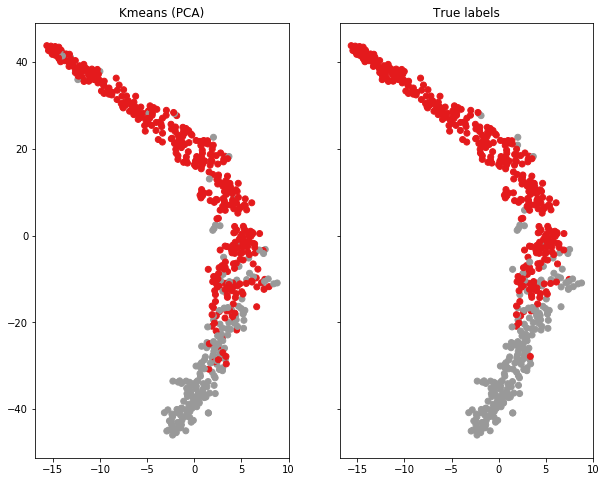

In [12]:
pca2 = PCA(n_components=5, random_state=0)
X_pca2 = pca2.fit_transform(X_scale)
print('explained_variance_ratio_ =', sum(pca2.explained_variance_ratio_))
PCA_visualization(X_pca2, y_true)

kmeans_pca2 = KMeans(n_clusters=2, random_state=0)
y_kmeans_pca2 = kmeans_pca2.fit_predict(X_pca2)

print(contingency_matrix(y_true, y_kmeans_pca2))
print(accuracy_score(y_true, y_kmeans_pca2))
print('adjusted_rand_score =', adjusted_rand_score(y_true, y_kmeans_pca2))
print('purity =', purity_score(y_true, y_kmeans_pca2))
print('Clustering accuracy:', 1 - np.sum(abs(y_kmeans_pca2-y_true))/X.shape[0])
display_cluster(y_true, y_kmeans_pca2, 'Kmeans (PCA)')